# Examples - Array
https://dask.pydata.org/en/latest/examples-tutorials.html#array

In [1]:
import os
import numpy as np
import h5py
import dask

data_path = '../dask-tutorial/data'

C:\Softwares\Python\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Array 
### Creating Dask arrays from NumPy arrays
We can create Dask arrays from any object that implements NumPy slicing, like a numpy.ndarray or on-disk formats like h5py or netCDF Dataset objects. **This is particularly useful with on disk arrays that don’t fit in memory** but, for simplicity’s sake, we show how this works on a NumPy array.

In [2]:
import dask.array as da

x = np.arange(1000)
y = da.from_array(x, chunks=(100))
y.mean().compute() 

499.5

### Creating Dask arrays from HDF5 Datasets
We can construct dask array objects from other array objects that support numpy-style slicing. In this example, we wrap a dask array around an HDF5 dataset, chunking that dataset into blocks of size (1000, 1000):

In [3]:
# import h5py, os
# import numpy as np
  
# filename = 'myfile.hdf5'
# file = os.path.join(data_path, filename)

# total_size = 1000000
# chunks = 1000

# if not os.path.exists(file):
#     with h5py.File(file) as f:
#         dset = f.create_dataset('/x', 
#                                 shape = (total_size,), 
#                                 dtype = np.float32,
#                                 chunks=(chunks,),
#                                 compression='gzip',
#                                 compression_opts=9) 
        
#         for i in range(0, total_size, chunks):
#             dset[i: i + chunks] = np.random.exponential(size=chunks)

In [4]:
import dask.array as da

filename = 'myfile.hdf5'
file = os.path.join(data_path, filename)

h5file = h5py.File(file)#, mode = 'r')
dataset = h5file['/x']

# build Dask Array from HDF5 dataset
x = da.from_array(dataset, chunks = dataset.chunks)

y = x[::10000] - x.mean(axis=0)

%time print('result:', y.compute())

h5file.close()

result: [-0.64674985 -0.22668874 -0.27774346  2.559743    0.2979015  -0.5956613
  0.79906476 -0.25978506 -0.6400137  -0.50122947 -0.5501237  -0.45786148
 -0.81786805 -0.6803148   1.8183072   0.0706774  -0.34766126 -0.2607717
 -0.9230949  -0.40851784 -0.2787838  -0.74477565 -0.8358296  -0.7863423
  0.9568     -0.5427391   1.3723187  -0.08791035  2.8399603  -0.7163671
  1.5204368  -0.7691104  -0.52979404 -0.50032794 -0.5012726  -0.6958561
  0.10943246 -0.29757774  2.0415967  -0.6752656  -0.5851799  -0.6956012
 -0.7376877   0.04875898  0.4183973   0.53458846 -0.29217488 -0.68081343
  0.38699257 -0.42110473  0.73694146 -0.56270605 -0.60957325  0.28478825
  0.08592284  0.05933285 -0.88665557 -0.88949794 -0.957826   -0.7015122
  1.2569599  -0.7414051   0.30147684  1.1287274   2.2218735  -0.30781156
 -0.50330496  0.51573336  1.5444198   2.7049658   0.9826366   0.74960566
 -0.4028632   0.36163366 -0.8244845  -0.1751982  -0.10236657 -0.3164003
 -0.76260257  0.37822425 -0.03461301  0.96427107  1

In [5]:
x.shape

(1000000,)

In [6]:
x

dask.array<array, shape=(1000000,), dtype=float32, chunksize=(1000,)>

In [7]:
type(x)

dask.array.core.Array

In [8]:
x.name

'array-08aab3c4c13f8b13ca2d270967be5083'

In [9]:
dict(x.dask)

{('array-08aab3c4c13f8b13ca2d270967be5083',
  0): (<function dask.array.core.getter>, 'array-original-08aab3c4c13f8b13ca2d270967be5083', (slice(0, 1000, None),)),
 ('array-08aab3c4c13f8b13ca2d270967be5083',
  1): (<function dask.array.core.getter>, 'array-original-08aab3c4c13f8b13ca2d270967be5083', (slice(1000, 2000, None),)),
 ('array-08aab3c4c13f8b13ca2d270967be5083',
  2): (<function dask.array.core.getter>, 'array-original-08aab3c4c13f8b13ca2d270967be5083', (slice(2000, 3000, None),)),
 ('array-08aab3c4c13f8b13ca2d270967be5083',
  3): (<function dask.array.core.getter>, 'array-original-08aab3c4c13f8b13ca2d270967be5083', (slice(3000, 4000, None),)),
 ('array-08aab3c4c13f8b13ca2d270967be5083',
  4): (<function dask.array.core.getter>, 'array-original-08aab3c4c13f8b13ca2d270967be5083', (slice(4000, 5000, None),)),
 ('array-08aab3c4c13f8b13ca2d270967be5083',
  5): (<function dask.array.core.getter>, 'array-original-08aab3c4c13f8b13ca2d270967be5083', (slice(5000, 6000, None),)),
 ('arra

In [10]:
len(x.chunks[0])

1000

In [11]:
dataset.chunks

(1000,)

Often we have many such datasets. We can use the **stack or concatenate** functions to bind many dask arrays into one:

In [12]:
import h5py, os
import numpy as np
  
filename = 'myfile.hdf5'
file = os.path.join(data_path, filename)

total_size = 1000
chunks = 10
files_count = 5

for i in range(files_count):
    file_n = file + '_' + str(i)
    
    if not os.path.exists(file_n):
        with h5py.File(file_n) as f:
            dset = f.create_dataset('/x', 
                                    shape = (total_size,), 
                                    dtype = np.float32,
                                    chunks=(chunks,),
                                    compression='gzip',
                                    compression_opts=9) 

            for j in range(0, total_size, chunks):
                dset[j: j + chunks] = np.random.exponential(size=chunks)

In [13]:
h5files = [h5py.File(file + '_' + str(i)) for i in range(files_count)]

# read HDF5 datasets
datasets = [h5file['/x'] for h5file in h5files]

# build Dask Arrays from HDF5 datasets
arrays = [da.from_array(dataset, chunks=dataset.chunks) for dataset in datasets]

# Stack along a new first axis
x = da.stack(arrays, axis=0)  

y = x[::10000] - x.mean(axis=0)

%time print('result:', y.compute())

for f in h5files:
    f.close()

result: [[ 1.39408141e-01 -1.30521119e-01 -9.11982656e-02 -6.49831533e-01
   5.46713829e-01  9.25823867e-01 -1.89516068e-01 -1.07236910e+00
   5.90080321e-02 -1.98996797e-01 -7.16921091e-02  3.92208874e-01
   1.30079079e+00 -8.50813150e-01 -1.13900721e+00 -1.23528612e+00
  -1.53187811e-01  5.84907889e-01  3.02744794e+00  3.27457786e-01
  -2.13315368e-01  6.29904747e-01 -7.89417148e-01 -2.57990092e-01
   1.16168737e-01 -1.84841037e-01 -8.56849968e-01 -3.40033054e-01
   9.77181792e-02  1.93398476e-01 -5.71385145e-01  2.64661312e-02
  -7.96267092e-01  1.59211397e+00  4.13043308e+00 -7.23660886e-02
  -6.29198551e-03 -5.43738186e-01 -9.06084061e-01  5.76979399e-01
  -9.14161682e-01  1.21650028e+00  8.08902979e-01 -1.30181074e-01
  -7.69602299e-01 -3.34665954e-01  4.58649397e-01  8.94255400e-01
   2.48130798e-01 -5.16349912e-01 -1.21903932e+00 -5.89455843e-01
  -3.62549067e-01  2.87713528e+00  7.03425288e-01 -1.67484403e-01
  -6.78926229e-01 -1.13193619e+00  9.26333189e-01  6.12619817e-01
  

In [14]:
x.shape

(5, 1000)

Note that ***none of the data is loaded into memory yet***, the ***dask array just contains a graph of tasks showing how to load the data***. This allows dask.array to do work on datasets that don’t fit into RAM.

### Creating random arrays
In a simple case, we can create arrays with random data using the **da.random** module.

In [15]:
import dask.array as da

total_size = 1000
chunks = 10

x = da.random.normal(0, 1, size=(total_size, total_size), chunks=(chunks, chunks))
x

dask.array<da.random.normal, shape=(1000, 1000), dtype=float64, chunksize=(10, 10)>

In [16]:
type(x)

dask.array.core.Array

In [17]:
x = da.ones(shape=(total_size, total_size), chunks=(chunks, chunks))
x.compute()

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])

In [18]:
x = da.zeros(shape=(total_size, total_size), chunks=(chunks, chunks))
x.compute()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

### Build Custom Dask.Array Function
As discussed in the [array design document](https://dask.pydata.org/en/latest/array-design.html) to create a dask Array object we need the following:

- A dask graph
- A name specifying a set of keys within that graph
- A chunks tuple giving chunk shape information
- A NumPy dtype

Often dask.array functions take other Array objects as inputs along with parameters, add tasks to a new dask dictionary, create a new chunks tuple, and then construct and return a new Array object. The hard parts are invariably creating the right tasks and creating a new chunks tuple. Careful review of the array design document is suggested.

#### Example eye
Consider this simple example with the eye function.

In [19]:
from dask.base import tokenize
from dask.array import Array

def eye(n, blocksize):
    n_blocks_row = n // blocksize
    n_blocks_col = n // blocksize

    name = 'eye-' + tokenize(n, blocksize)  # unique identifier
    
    chunks = ((blocksize,) * n_blocks_row,
              (blocksize,) * n_blocks_col)

    dsk = {(name, i, j): (np.eye, blocksize) if i == j else (np.zeros, (blocksize, blocksize))
           for i in range(n_blocks_row) for j in range(n_blocks_col)}

    dtype = np.eye(0).dtype  # take dtype default from numpy

    return Array(dsk, name, chunks, dtype)

In [20]:
n = 10
blocksize = 4
n // blocksize

2

In [21]:
chunks = ((blocksize,) * (n // blocksize), (blocksize,) * (n // blocksize))
chunks

((4, 4), (4, 4))

In [22]:
x = eye(n, blocksize)
x

dask.array<eye, shape=(8, 8), dtype=float64, chunksize=(4, 4)>

In [23]:
type(x)

dask.array.core.Array

In [24]:
x.compute()

array([[1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1.]])

In [25]:
x.name

'eye-f0f40b74f0beff6100b7591e2b108d3e'

In [26]:
dict(x.dask)

{('eye-f0f40b74f0beff6100b7591e2b108d3e',
  0,
  0): (<function numpy.lib.twodim_base.eye>, 4),
 ('eye-f0f40b74f0beff6100b7591e2b108d3e',
  0,
  1): (<function numpy.core.multiarray.zeros>, (4, 4)),
 ('eye-f0f40b74f0beff6100b7591e2b108d3e',
  1,
  0): (<function numpy.core.multiarray.zeros>, (4, 4)),
 ('eye-f0f40b74f0beff6100b7591e2b108d3e',
  1,
  1): (<function numpy.lib.twodim_base.eye>, 4)}

In [27]:
x.chunks

((4, 4), (4, 4))

In [28]:
x.dtype

dtype('float64')

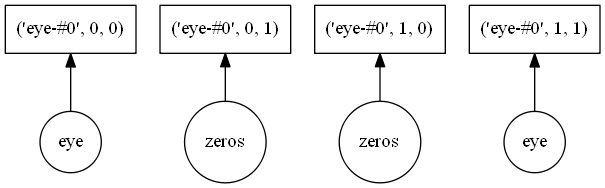

In [29]:
x.visualize()

#### Keys of the Dask graph
By special convention we refer to each block of the array with a tuple of the form (name, i, j, k) for i, j, k being the indices of the block, ranging from 0 to the number of blocks in that dimension. The dask graph must hold key-value pairs referring to these keys. It likely also holds other key-value pairs required to eventually compute the desired values, for example
```python
{
 ('x', 0, 0): (add, 1, ('y', 0, 0)),
 ('x', 0, 1): (add, 1, ('y', 0, 1)),
 ...
 ('y', 0, 0): (getitem, dataset, (slice(0, 1000), slice(0, 1000))),
 ('y', 0, 1): (getitem, dataset, (slice(0, 1000), slice(1000, 2000)))
 ...
}
```
The name of an Array object can be found in the name attribute. One can get a nested list of keys with the ._keys() method. One can flatten down this list with dask.array.core.flatten(); this is sometimes useful when building new dictionaries.

#### Example diag
Consider the function diag that takes a 1d vector and produces a 2d matrix with the values of the vector along the diagonal. Consider the case where the input is a 1d array with chunk sizes (2, 3, 4) in the first dimension like this:
```python
[x_0, x_1], [x_2, x_3, x_4], [x_5, x_6, x_7, x_8]
```
We need to create a 2d matrix with chunks equal to ((2, 3, 4), (2, 3, 4)) where the ith block along the diagonal of the output is the result of calling np.diag on the ith block of the input and all other blocks are zero.

In [30]:
from dask.base import tokenize
from dask.array import Array

def diag(v):
    """Construct a diagonal array, with ``v`` on the diagonal."""
    assert v.ndim == 1

    name = 'diag-' + tokenize(v)  # unique identifier
    
    chunks = (v.chunks[0], v.chunks[0])  # repeat chunks twice

    dsk = {(name, i, j): (np.diag, (v.name, i)) if i == j else (np.zeros, (v.chunks[0][i], v.chunks[0][j]))
            for i in range(len(v.chunks[0]))
            for j in range(len(v.chunks[0]))}

    dsk.update(v.dask)  # include dask graph of the input

    dtype = v.dtype     # output has the same dtype as the input

    return Array(dsk, name, chunks, dtype)

In [31]:
np.diag((x.name, 0))

array([['eye-f0f40b74f0beff6100b7591e2b108d3e', ''],
       ['', '0']], dtype='<U36')

In [32]:
x = da.arange(9, chunks=((2, 3, 4),))
x

dask.array<arange, shape=(9,), dtype=int32, chunksize=(2,)>

In [33]:
x.compute()

array([0, 1, 2, 3, 4, 5, 6, 7, 8])

In [34]:
x.name

'arange-dcceef6f8c22a39f37623f77956b9bcf'

In [35]:
dict(x.dask)

{('arange-dcceef6f8c22a39f37623f77956b9bcf',
  0): (<function dask.array.chunk.arange>, 0, 2, 1, 2, dtype('int32')),
 ('arange-dcceef6f8c22a39f37623f77956b9bcf',
  1): (<function dask.array.chunk.arange>, 2, 5, 1, 3, dtype('int32')),
 ('arange-dcceef6f8c22a39f37623f77956b9bcf',
  2): (<function dask.array.chunk.arange>, 5, 9, 1, 4, dtype('int32'))}

In [36]:
x.ndim

1

In [37]:
x.chunks[0]

(2, 3, 4)

In [38]:
M = diag(x)
M

dask.array<diag, shape=(9, 9), dtype=int32, chunksize=(2, 2)>

In [39]:
M.name

'diag-efd233e309e3b59bd9acd7f5bc74a12d'

In [40]:
M.chunks

((2, 3, 4), (2, 3, 4))

In [41]:
dict(M.dask)

{('arange-dcceef6f8c22a39f37623f77956b9bcf',
  0): (<function dask.array.chunk.arange>, 0, 2, 1, 2, dtype('int32')),
 ('arange-dcceef6f8c22a39f37623f77956b9bcf',
  1): (<function dask.array.chunk.arange>, 2, 5, 1, 3, dtype('int32')),
 ('arange-dcceef6f8c22a39f37623f77956b9bcf',
  2): (<function dask.array.chunk.arange>, 5, 9, 1, 4, dtype('int32')),
 ('diag-efd233e309e3b59bd9acd7f5bc74a12d',
  0,
  0): (<function numpy.lib.twodim_base.diag>,
  ('arange-dcceef6f8c22a39f37623f77956b9bcf', 0)),
 ('diag-efd233e309e3b59bd9acd7f5bc74a12d',
  0,
  1): (<function numpy.core.multiarray.zeros>, (2, 3)),
 ('diag-efd233e309e3b59bd9acd7f5bc74a12d',
  0,
  2): (<function numpy.core.multiarray.zeros>, (2, 4)),
 ('diag-efd233e309e3b59bd9acd7f5bc74a12d',
  1,
  0): (<function numpy.core.multiarray.zeros>, (3, 2)),
 ('diag-efd233e309e3b59bd9acd7f5bc74a12d',
  1,
  1): (<function numpy.lib.twodim_base.diag>,
  ('arange-dcceef6f8c22a39f37623f77956b9bcf', 1)),
 ('diag-efd233e309e3b59bd9acd7f5bc74a12d',
  1,

In [42]:
M.compute()

array([[0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 2, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 3, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 4, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 5, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 6, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 7, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 8]])

#### Example Lazy Reader
Dask may also be used as a lazy loader. Consider the following function which takes filenames and a reader:

In [43]:
from dask.array import Array
from dask.base import tokenize

def read_custom(reader, filenames):
    '''
    This creates a dask array based on numpy files of the same length.

    Parameters
    ----------
    reader: callable
        The function that reads the files
        The reader should take a filename as an argument and return a numpy
        array (np.ndarray instance).

    filenames : List[str]
        the names of the files of the same length.
        These must be numpy files of same shape and dtype
        This will concatenate them together as the same dask array.

    Examples
    --------
    read_custom(np.load, ['foo1.npy', 'foo1.npy'])
    read_custom(skimage.io.imread, ['1.jpg', '2.jpg', '3.jpg'])
    '''
    # Read one file to get example shape and dtype

    name = 'read_custom-' + tokenize(reader, *filenames)  # unique identifier

    example = reader(filenames[0])

    chunks = ((1,) * len(filenames),) + tuple((d,) for d in example.shape)  # ex. ((1, 1, 1), (4,), (5,))
    
    dsk = {(name, i, 0, 0): (operator.getitem,
                             (reader, fn),  # read array from file
                             (None, Ellipsis))  # add extra dimension like x[None, ...]           
           for i, fn in enumerate(filenames)}

    return Array(dsk, name, chunks, example.dtype)

In [44]:
((1,) * 3,) + tuple((d,) for d in (4, 5))

((1, 1, 1), (4,), (5,))

This may be useful when processing time series of images, for instance. Alternatively, people often do this in practice by just using ***dask.delayed*** as in the following example:

In [45]:
import skimage.io
import dask.array as da
from dask import delayed
# import glob

urls = ['sample.jpg', 'sample2.jpg']

# filenames = sorted(glob.glob('*.jpg'))
reader = skimage.io.imread
sample = reader('sample.jpg')

imread = delayed(reader, pure=True)  # Lazy version of imread
lazy_images = [imread(url) for url in urls]     # Lazily evaluate imread on each url

arrays = [da.from_delayed(lazy_image,           # Construct a small Dask array
                          dtype=sample.dtype,   # for every lazy value
                          shape=sample.shape)
          for lazy_image in lazy_images]

stack = da.stack(arrays, axis=0)                # Stack all small Dask arrays into one
stack

dask.array<stack, shape=(2, 177, 284, 3), dtype=uint8, chunksize=(1, 177, 284, 3)>

In [46]:
stack.compute().shape

(2, 177, 284, 3)